#機械学習（回帰）

###各種インポート

In [21]:
!pip install japanize_matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from sklearn.covariance import MinCovDet as MCD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import PolynomialFeatures as PF

from sklearn.linear_model import SGDRegressor as SGDR
from sklearn.linear_model import Lasso as L
from sklearn.linear_model import ElasticNet as EN
from sklearn.linear_model import Ridge as R
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor as BR
from sklearn.tree import DecisionTreeRegressor as DTR

import warnings
import pickle

#警告文の非表示
warnings.simplefilter("ignore")

##関数の定義

###外れ値の除外

In [22]:
def outliers(df):
    df2 = df
    #種類が少ない列は除外
    for name in df2.columns:
        if len(df2[name].unique()) < 5:
            df2 = df2.drop(name,axis=1)
    
    #除外対象がない場合終了
    if len(df2.columns) == 0:
        print("外れ値除外対象なし")
        return df

    #箱ひげ図の描画
    for plt_x in df2.columns:
        plt.boxplot(df2[plt_x])
        plt.title(plt_x)
        plt.show()

    #マハラノビス距離で外れ値の除外
    mcd = MCD(random_state= 0).fit(df2)
    distance = pd.Series(mcd.mahalanobis(df2),index=df2.index)
    tmp = distance.describe()
    iqr = tmp["75%"] - tmp["25%"]
    upper = 1.5 * iqr + tmp["75%"]
    lower = tmp["25%"] - 1.5 * iqr
    outliner = distance[ (distance > upper) | (distance < lower) ]
    df = df.drop(outliner.index,axis = 0)
    
    return df

###最適特徴量選択

In [23]:
def feature(x,t,target,specify_degree,col=[-1]):
    #特徴量一括追加
    pf = PF(degree = specify_degree,include_bias = False).fit(x)
    pf_x = pf.transform(x)
    t_df = pd.DataFrame(t)
    x_df = pd.DataFrame(pf_x,index=t_df.index)
    pf_df = pd.concat([x_df,t_df],axis = 1)

    #相関係数の計算
    se = pf_df.corr()[target]
    se = se.map(abs)
    se = se.sort_values(ascending = False)
    se_df = pd.DataFrame(se)

    if col[0] == -1: 
        col_len = len(se_df[se_df[target] > 0.25].index)
        x_col = se_df.index[1:col_len+1]
    else:
        #カラムの指定がある場合指定されたカラムを使用
        x_col = col

    x = pf_df[x_col]
    t = pf_df[[target]]
    
    return x,t

###標準化

In [24]:
def scaler(x,t):
    #訓練データと検証データに分割
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size = 0.2,random_state=0)

    #標準化
    sc_x_model = SS().fit(x_train)
    sc_y_model = SS().fit(y_train)
    sc_x_train = sc_x_model.transform(x_train)
    sc_x_val = sc_x_model.transform(x_val)
    sc_y_train = sc_y_model.transform(y_train)
    sc_y_val = sc_y_model.transform(y_val)
    
    return sc_x_model,sc_y_model,sc_x_train,sc_x_val,sc_y_train,sc_y_val

###SGDRegressorモデル

In [25]:
def sgdr_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    count = 0

    #パラメータ調整
    for i in range(1,10001):
        p_model = SGDR(max_iter=i).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)

        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            count = 0
        else:
            count += 1
            if count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = SGDR(max_iter=i).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break

    return p_model,p_train_score,p_val_score

###Lassoモデル

In [26]:
def l_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    count = 0

    #パラメータ調整
    for i in range(1,10001):
        p_model = L(alpha=i/1000).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)
        
        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            count = 0
        else:
            count += 1
            if count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = L(alpha=i/1000).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break
    
    return p_model,p_train_score,p_val_score

###ElatsicNetモデル

In [27]:
def en_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    count = 0

    #パラメータ調整
    for i in range(1,10001):
        p_model = EN(alpha=i/1000).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)
        
        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            count = 0
        else:
            count += 1
            if count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = EN(alpha=i/1000).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break

    return p_model,p_train_score,p_val_score

###Ridgeモデル

In [28]:
def r_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    count = 0

    #パラメータ調整
    for i in range(1,10001):
        p_model = R(alpha=i/1000).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)
        
        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            count = 0
        else:
            count += 1
            if count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = R(alpha=i/1000).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break
        
    return p_model,p_train_score,p_val_score

###linearSVRモデル

In [29]:
def lsvr_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    count = 0

    #パラメータ調整
    for i in range(1,10001):
        p_model = SVR(kernel="linear", C=i/10, epsilon=2.0).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)
        
        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            count = 0
        else:
            count += 1
            if count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = SVR(kernel="linear", C=i/10, epsilon=2.0).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break

    return p_model,p_train_score,p_val_score

###rbfSVRモデル

In [30]:
def rsvr_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    i_count = 0

    #パラメータ調整
    for i in range(1,10001):
        j_count = 0
        for j in range(1,10001):
            p_model = SVR(kernel="rbf", C=i/10, gamma=j/100, epsilon=0.1).fit(sc_x_train,sc_y_train)
            p_train_score = p_model.score(sc_x_train,sc_y_train)
            p_val_score = p_model.score(sc_x_val,sc_y_val)

            if p_val_score > p_score:
                #決定係数が高ければ更新
                p_score = p_val_score
                j_count = 0
            else:
                j_count += 1
                if j_count > 5:
                    #5回続けて決定係数が下がった場合、変数を戻しbreak
                    j -= 5
                    p_model = SVR(kernel="rbf", C=i/10, gamma=j/100, epsilon=0.1).fit(sc_x_train,sc_y_train)
                    p_train_score = p_model.score(sc_x_train,sc_y_train)
                    p_val_score = p_model.score(sc_x_val,sc_y_val)
                    break

        p_model = SVR(kernel="rbf", C=i/10, gamma=j/100, epsilon=0.1).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)

        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            i_count = 0
        else:
            i_count += 1
            if i_count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = SVR(kernel="rbf", C=i/10, gamma=j/100, epsilon=0.1).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break

    return p_model,p_train_score,p_val_score

###BaggingRegressorモデル

In [31]:
def br_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    p_score = -1
    count = 0

    #パラメータ調整
    for i in range(1,10001):
        p_model = BR(DTR(), n_estimators=i, max_samples=0.3).fit(sc_x_train,sc_y_train)
        p_train_score = p_model.score(sc_x_train,sc_y_train)
        p_val_score = p_model.score(sc_x_val,sc_y_val)
        if p_val_score > p_score:
            #決定係数が高ければ更新
            p_score = p_val_score
            count = 0
        else:
            count += 1
            if count > 5:
                #5回続けて決定係数が下がった場合、変数を戻しbreak
                i -= 5
                p_model = BR(DTR(), n_estimators=i, max_samples=0.3).fit(sc_x_train,sc_y_train)
                p_train_score = p_model.score(sc_x_train,sc_y_train)
                p_val_score = p_model.score(sc_x_val,sc_y_val)
                break
    
    return p_model,p_train_score,p_val_score

###最適モデル選択

In [32]:
def model_selection(sc_x_train,sc_x_val,sc_y_train,sc_y_val):
    print("▮",end="")
    val_score,model,train_score,val_score = -1,-1,-1,-1

    #SGDRegressorモデル
    p_sgdr_model,p_sgdr_train_score,p_sgdr_val_score = sgdr_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_sgdr_val_score > val_score:
        #決定係数が高ければ更新
        model = p_sgdr_model
        train_score = p_sgdr_train_score
        val_score = p_sgdr_val_score

    #Lassoモデル
    p_l_model,p_l_train_score,p_l_val_score = l_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_l_val_score > val_score:
        #決定係数が高ければ更新
        model = p_l_model
        train_score = p_l_train_score
        val_score = p_l_val_score
   
    print("▮",end="")
   
    #ElasticNetモデル
    p_en_model,p_en_train_score,p_en_val_score = en_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_en_val_score > val_score:
        #決定係数が高ければ更新
        model = p_en_model
        train_score = p_en_train_score
        val_score = p_en_val_score

    #Rigdeモデル
    p_r_model,p_r_train_score,p_r_val_score = r_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_r_val_score > val_score:
        #決定係数が高ければ更新
        model = p_r_model
        train_score = p_r_train_score
        val_score = p_r_val_score

    print("▮",end="")

    #linearSVRモデル
    p_lsvr_model,p_lsvr_train_score,p_lsvr_val_score = lsvr_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_lsvr_val_score > val_score:
        #決定係数が高ければ更新
        model = p_lsvr_model
        train_score = p_lsvr_train_score
        val_score = p_lsvr_val_score

    print("▮",end="")

    #rbfSVRモデル
    p_rsvr_model,p_rsvr_train_score,p_rsvr_val_score = rsvr_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_rsvr_val_score > val_score:
        #決定係数が高ければ更新
        model = p_rsvr_model
        train_score = p_rsvr_train_score
        val_score = p_rsvr_val_score

    #BaggingRegressorモデル
    p_br_model,p_br_train_score,p_br_val_score = br_model(sc_x_train,sc_x_val,sc_y_train,sc_y_val)
    if p_br_val_score > val_score:
        #決定係数が高ければ更新
        model = p_br_model
        train_score = p_br_train_score
        val_score = p_br_val_score

    print("▮▮|",end="")
    
    return model,train_score,val_score

###最適処理

In [33]:
def optimal(df,target):
    print("0%  20%  40%  60%  80%  100%\n|",end="")

    #特徴量、正解データ準備
    x_col = df.drop(target,axis = 1).columns
    x = df[x_col]
    t = df[[target]]
    val_score,col = -1,[-1]

    #特徴量次数分繰り返し
    for i in range(1,4):

        #特徴量一括追加
        x2,t2 = feature(x,t,target,i)
        
        #標準化
        p_sc_x_model,p_sc_y_model,sc_x_train,sc_x_val,sc_y_train,sc_y_val = scaler(x2,t2)

        #最適モデル選択
        p_model,p_train_score,p_val_score = model_selection(sc_x_train,sc_x_val,sc_y_train,sc_y_val)

        #決定係数が高ければ更新
        if p_val_score > val_score:
            model = p_model
            train_score = p_train_score
            val_score = p_val_score
            specify_degree = i
            sc_x_model = p_sc_x_model
            sc_y_model = p_sc_y_model
            col = x2.columns

    print("▮▮▮▮▮▮|")
    print("選択モデル:{}\n訓練データ決定係数:{}\t検証データ決定係数:{}\n特徴量次数:{}".format(model,round(train_score,3),round(val_score,3),specify_degree))

    return model,specify_degree,sc_x_model,sc_y_model,col

##実行文

###データフレームの作成

In [34]:
#データフレームの読み込み
df = pd.read_csv("auto_mgp.csv",encoding = "cp932")

#正解データの列名
target = "MPG"

df.head(3)

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1


###ダミー変数化

In [35]:
#質的データ列の抽出
dum_col = df.select_dtypes("object").columns
if len(dum_col) > 0:
    df2 = pd.get_dummies(df[dum_col],drop_first=False)
    df2 = pd.concat([df,df2],axis=1)
    df2 = df2.drop(columns=dum_col)
else:
    #質的データがない場合変数名のみ変更
    print("ダミー変数化対象なし")
    df2 = df
    
df2.head(3)

ダミー変数化対象なし


,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1


###欠損値処理

Unnamed: 0      0
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


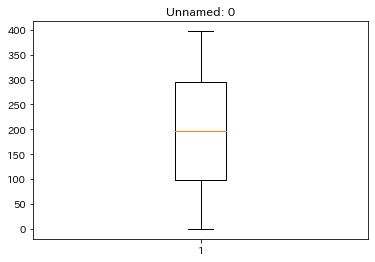

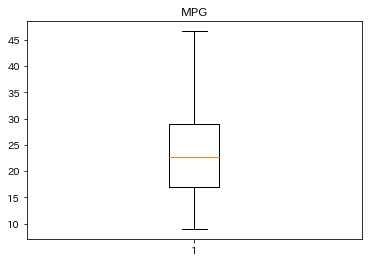

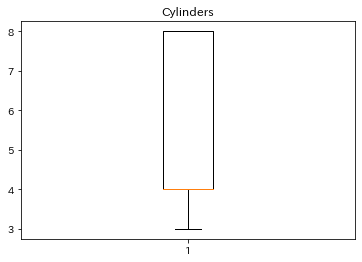

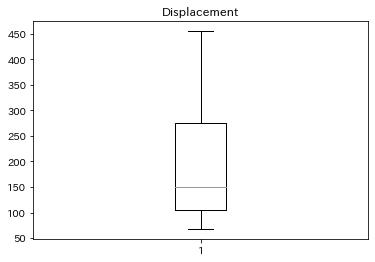

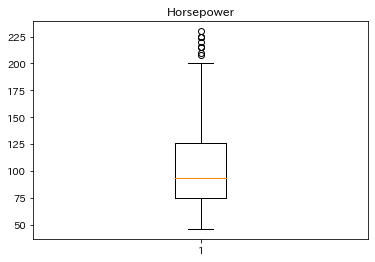

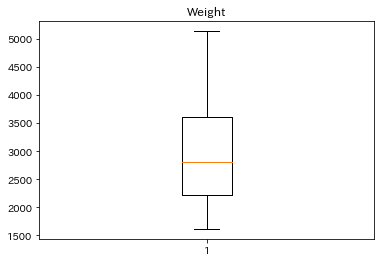

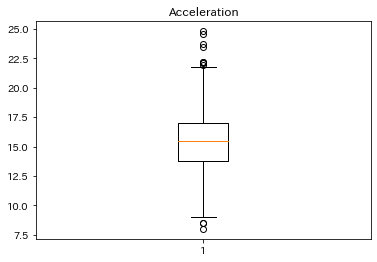

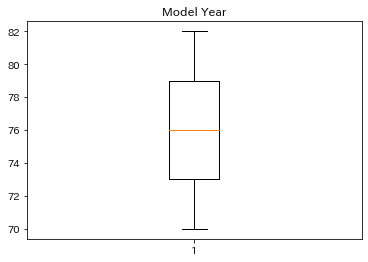

0%  20%  40%  60%  80%  100%
|▮▮▮▮▮▮|▮▮▮▮▮▮|▮▮▮▮▮▮|▮▮▮▮▮▮|
選択モデル:ElasticNet(alpha=0.002)
訓練データ決定係数:0.935	検証データ決定係数:0.949
特徴量次数:2


,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1


In [36]:
df3 = df2

non = df3.isnull().sum()
print(non)

non_f = False

for i in range(len(non)):
    if non[i] > 0:
        non_f = True

if non_f:
    #欠損値のある列の検索
    non_col = df3.loc[:,df3.isnull().any()].columns

    #欠損値処理のための欠損値行の削除
    non_df = df3.dropna()

    #欠損値処理のための外れ値の除外
    non_df = outliers(non_df)

    #欠損値のある列分繰り返し
    for name in non_col:
        #欠損値処理のための最適処理
        model,specify_degree,sc_x_model,sc_y_model,col = optimal(non_df,name)
        
        #欠損値処理のための特徴量、正解データ準備
        non_data = df3.loc[df3[name].isnull()]
        non_x_col = non_data.drop(name,axis = 1).columns
        x = non_data[non_x_col]
        t = non_data[[name]]
        non_x,non_t = feature(x,t,name,specify_degree,col)

        #穴埋値の予測
        sc_non_x = sc_x_model.transform(non_x)
        sc_pred = model.predict(sc_non_x)
        pred = sc_y_model.inverse_transform([sc_pred])
        t_pred = []
        for val in pred[0]:
            t_pred.append(val)

        #欠損値の補完
        df3.loc[df3[name].isnull(),name] = t_pred

else:
    #欠損値がない場合変数名のみ変更
    print("欠損値処理対象なし")

df3.head(3)

###訓練・検証データとテストデータに分割

In [37]:
train_val,test = train_test_split(df3,test_size=0.2,random_state=0)

###外れ値の除外

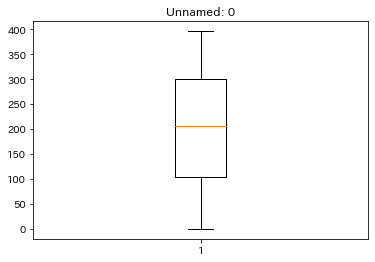

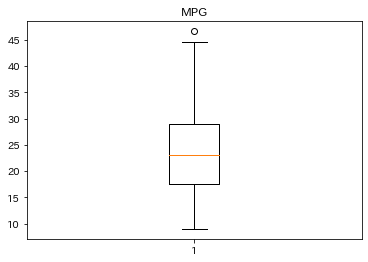

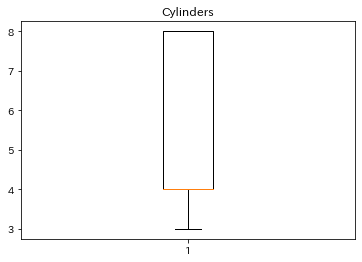

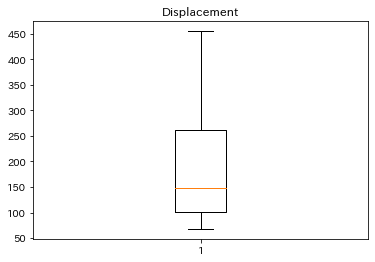

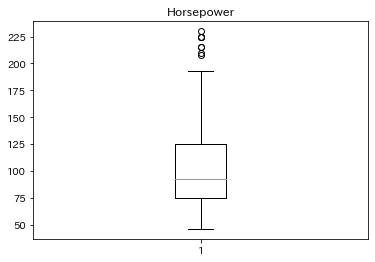

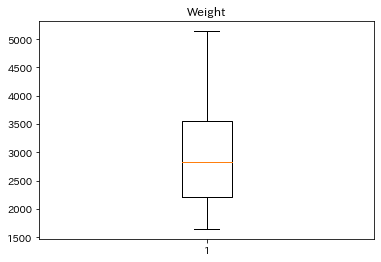

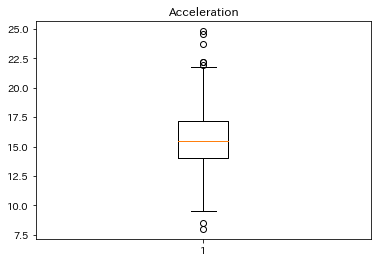

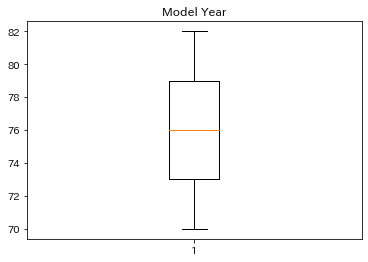

In [38]:
train_val2 = outliers(train_val)

###学習・評価

In [39]:
#訓練・検証データの最適処理
model,specify_degree,sc_x_model,sc_y_model,col = optimal(train_val2,target)

#テストデータの特徴量、正解データ準備
x_col = test.drop(target,axis = 1).columns
x = test[x_col]
t = test[[target]]

x_test,t_test = feature(x,t,target,specify_degree,col)

#テストデータの標準化
sc_x_test = sc_x_model.transform(x_test)
sc_y_test = sc_y_model.transform(t_test)

#テストデータの決定係数
test_score= model.score(sc_x_test,sc_y_test)
print("テストデータ決定係数:{}".format(round(test_score,3)))

0%  20%  40%  60%  80%  100%
|▮▮▮▮▮▮|▮▮▮▮▮▮|▮▮▮▮▮▮|▮▮▮▮▮▮|
選択モデル:BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_samples=0.3,
                 n_estimators=22)
訓練データ決定係数:0.927	検証データ決定係数:0.926
特徴量次数:1
テストデータ決定係数:0.872


###モデルの保存

In [40]:
with open("regression.pkl","wb") as f:
    pickle.dump(model,f)

with open("sc_x_model","wb") as f:
    pickle.dump(sc_x_model,f)

with open("sc_y_model","wb") as f:
    pickle.dump(sc_y_model,f)